<a href="https://colab.research.google.com/github/lamantinushka/cam_summarisation/blob/master/TextRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

We have set of 538 samples generated by CAM. Each sample contains numerical score, objects and supportive sentences retrived by elastic search engine. For more detailed information please visit: link 

In [39]:
import json

In [40]:
data = []
for line in open('./mined_bow_str.json', 'r'):
    data.append(json.loads(line))

In [45]:
# usefull function that extracts all supporting sentences from the CAM output
def write_sentences(sample, sentences = None):
    if sentences is None:
        sentences = []
    for s in sample['object1']['sentences']:
        sentences.append(s['text'] + '\n')
    for s in sample['object2']['sentences']:
        sentences.append(s['text'] + '\n')
    return sentences

In [46]:
e =data[6]['object1']['sentences']

Let's choose some samples to compare model's performance

In [47]:
samples = [data[4], data[155], data[228]]

for s in samples:
  print(s['object1']['name'] + ' vs ' + s['object2']['name'])

python vs java
toyota vs nissan
tea vs juice


In [48]:
for s in samples:
    write_sentences(s)

# Graph Routine

TextRank is a graph method used for summarisation. It extracts vetices of the graph that are most important in terms of similarity function to all other verticies. We use networkx library implementation of PageRank algorithm, then we sort vertices and get top k sentences with the highest PageRank score.

In Graph-based Text Summarization Using Modified TextRank, C. Mallick et al., 2018, https://www.researchgate.net/publication/327136473_Graph-based_Text_Summarization_Using_Modified_TextRank there are two modifications of TextRank algorithm suggested for summarization task:
- prune graph so that only egdes with weights higher than average are left
- initialize TextRank with node weigt proportional to the importance of the edges incident to it

In [49]:
import networkx as nx

In [50]:
def prune_graph(scores):
    mean = np.array([s[2] for s in scores]).mean()
    pruned = []
    for s in scores:
        if s[2] > mean:
            pruned.append(s)
    return pruned

In [51]:
def init_pagerank(scores):
    weights = {}
    n_edges = {}
    for i, j, w in scores:
        prev_score, prev_n = weights.get(i, 0.0), n_edges.get(i, 0)
        weights[i] = w + prev_score
        n_edges[i] = 1 + prev_n
        prev_score, prev_n = weights.get(j, 0.0), n_edges.get(j, 0)
        weights[j] = w + prev_score
        n_edges[j] = 1 + prev_n
    for k in weights:
        v = weights[k]
        weights[k] = v/n_edges[k]
    return weights

In [52]:
import networkx as nx

def init_pagerank(scores):
    weights = {}
    n_edges = {}
    for i, j, w in scores:
        prev_score, prev_n = weights.get(i, 0.0), n_edges.get(i, 0)
        weights[i] = w + prev_score
        n_edges[i] = 1 + prev_n
        prev_score, prev_n = weights.get(j, 0.0), n_edges.get(j, 0)
        weights[j] = w + prev_score
        n_edges[j] = 1 + prev_n
    for k in weights:
        v = weights[k]
        weights[k] = v/n_edges[k]
    return weights


def extract_top(scores, k = 10, weighted_init = False):
    g = nx.Graph()
    g.add_weighted_edges_from(scores)
    if weighted_init:
        pr = nx.pagerank(g, nstart = init_pagerank(scores))
    else:
        pr = nx.pagerank(g)
    idxes = sorted(pr, key = lambda x: -pr[x])[:k]
    return idxes

# Chinese Whispers 
(Chris Biemann, 2006, https://www.aclweb.org/anthology/W06-3812.pdf)

Is an efficient graph clustering algorithm that on each iteration sets class of one of the vertices equal to the highest ranked class among the vertices neighbours. It is shown efficient for NLP tasks and does not requires pre-defined number of clusters.

It is suggested to cluster graph and build separate TextRank models for each cluster. We assume that each clusster will correspond to one important agrument  or topic. As a result, we may extract only the most high-ranked sentence from each cluster and use them as a complete summary of CAM output.

Here we use original implementation of Chinese Whispers availiable in PyPi. As edges weights we may use any similarity function presented below.

In [53]:
!pip install chinese_whispers

In [54]:
from chinese_whispers import chinese_whispers, aggregate_clusters

In [55]:
def cw_summarize(scores, k = None, weighted_init = False):
    g = nx.Graph()
    g.add_weighted_edges_from(scores)
    pos = nx.spring_layout(g)
    edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())
    nx.draw(g, pos, node_color='b', edgelist=edges, edge_color=weights)
    plt.show()
    chinese_whispers(g, weighting='log', iterations = 1) 

    scores = {(s[0], s[1]): s[2] for s in scores}

    clusters = []
    for label, cluster in sorted(aggregate_clusters(g).items(), key=lambda e: len(e[1]), reverse=True):
        clusters.append(cluster)
    
    print(len(clusters))
    tops = []
    for c in clusters:
        if len(c) == 1:
            tops.append(list(c)[0])
        else:
            scores_c = []
            for i in c:
                for j in c:
                    if (i, j) in scores:
                        scores_c.append((i, j, scores[(i, j)]))
            top_k = extract_top(scores_c, k = 1, weighted_init=weighted_init)
            tops.append(top_k[0])
    return tops

# Similarity Functions:

We use an original version of PageRank algorithm, we also compare it with suggested heuristic based on Chinese Whispers Algorithm.

Similarity between sentences can be defined in different ways, here we apply some of them:

### Words Co-occurence

In this approach we use number of words in common normalized by the cumulative length of both sentences. Here we use stemmer so that different forms of the same word are counted as the same token. We also do not take into consideration number of word occurence in sentences. 

Let's define sentence representation 
$$s = \{w: w = stemmer(\tilde{w}), \tilde{w} \in sentence \}$$
where $s$ is a set without repetition, then similarity function is
$$f(s_1, s_2) = \frac {\sum_{w \in s_1} \mathbb{1}(w \in s_2)}{|s_1| + |s_2|}$$
$$\mathbb{1}(w \in s_2) = 1 \ \text{if} \ w \in s_2, \ \text{else} \ 0$$


In [56]:
def similarity1(s1, s2):
    if len(s1) == 0 and len(s2) == 0:
        return 0.0

    inter = 0.0
    for w in s1:
        inter += 1
    return inter/((len(s1) + len(s2)))

It is also possible to exclude common words from the similarity function calculation. It can be usefull because only meaningfull words are used and common phrases do not affect the similarity. We use nltk stopwords here.

In [57]:
#make sure that stopwords are downloaded
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 110]
[nltk_data]     Connection timed out>


False

In [58]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [59]:
#use for Chinese Whispers:
#summarize = cw_summarize

#use for TextRank:
summarize = extract_top

exclude_common = True
prune = True
weighted_init = True

stemmer = SnowballStemmer(language='english')
tokenizer = RegexpTokenizer(r'\w+')
summaries = []
k = 10

for s in samples:
    raw_sentences = write_sentences(s)
    sentences = []
    for sentence in raw_sentences:
        words = tokenizer.tokenize(sentence)
        sentences.append(' '.join(words))
    sentences = list(set(sentences))
    word_sets = []
    for sentence in sentences:
        words = sentence.split()
        common = stopwords.words('english') + [s['object1']['name'], s['object2']['name']]
        if exclude_common:
            words = [w.lower() for w in words if w.lower() not in common]

        words = set([stemmer.stem(word) for word in words])
        word_sets.append(words)

    scores = []
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            
            scores.append((i, j, similarity1(word_sets[i], word_sets[j])))

    if prune:
        scores = prune_graph(scores)

    top_k = summarize(scores, k = k, weighted_init = weighted_init)

    summaries.append([sentences[i] for i in top_k])

In [60]:
for i, s in enumerate(samples):
    print(s['object1']['name'] + ' vs ' + s['object2']['name'] + ':')
    for sent in summaries[i]:
        print(sent + '.')
    print()

python vs java:
python than for java.
Aside from the perils of late binding the other major concern I have about Python for mission critical apps is that the Python designers didn t include a posse of security paranoids the way Java and JEE did so exploits are potentially more possible.
In practice I find that my Python programs perform somewhat better than Java probably because Python has many libraries implemented in C whereas Java has many pure Java libraries.
Using the decimal library in python with 90 significant digits is massive overkill but I plan to use those results as a baseline for comparison with both the java app and the python app.
most humorously the major reason python is touted over java is the reason you give for java over c python is even more high level than java meaning higher productivity.
BTW AFAIK the python language evolution is managed much in the same way that Java JSR for Java vs PEPs for Python JCP for Java vs PSF for Python.
Python is slower than Java.
Py

### TF-IDF

Term frequency – inverse document frequency is a common statistic used in number of natural language processing models. As a similarity function here we use cosine distance between tf-idf representations of the sentences:

$$f(s_1, s_2) = \frac {\left<s_1, s_2\right>}{\|s_1\|\|s_2\|}$$

where tf-idf of a sentence $s$ is a product of tf representation of a sentence and idf statistic of a set of documents retrieved by CAM for the given query:
$$s = tf \times idf$$
$$tf(t, s) = \frac{n_t}{|s|}$$, 
where $t$ is a term, s is a sentence and n_t is a number of occurence of term t in sentence s. Here we also use stemmer.

$$idf(t, S) = log \frac{|S|}{|\{s: t \in s \ \& \ s \in S\}|}$$,
where S is a set of documents, t is a term and s is a sentence from S.

In [61]:
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
import numpy as np

In [62]:
def make_vocab(sentences):
    counter = Counter()
    for s in sentences:
        words = s.split(' ')
        words = [stemmer.stem(word) for word in words]
        counter.update(words)

    vocab = {}
    i = 0
    for key in counter:
        vocab[key] = i
        i += 1
    return vocab

def compute_idf(sentences, vocab):
    d = np.zeros(len(vocab))
    word_sets = []
    for s in sentences:
        words = s.split()
        word_sets.append(set([stemmer.stem(word) for word in words]))

    for s in word_sets:
        for w in s:
            d[vocab[w]] += 1

    idf = np.log(len(sentences)/d)
    return idf

def tf_idf(sentence, vocab, idf):
    res = np.zeros(len(vocab))
    for w in sentence.split():
        res[vocab[stemmer.stem(w)]] += 1
    res /= res.sum()
    res *= idf
    return res

In [63]:
def similarity(s1, s2):
    return s1.dot(s2)/np.linalg.norm(s1)/np.linalg.norm(s2) 

In [ ]:
len(samples)

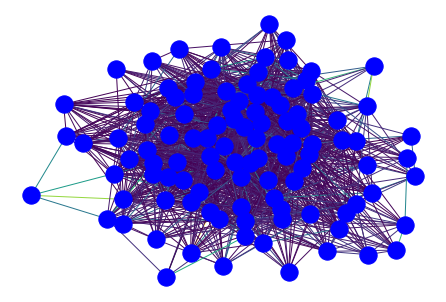

21


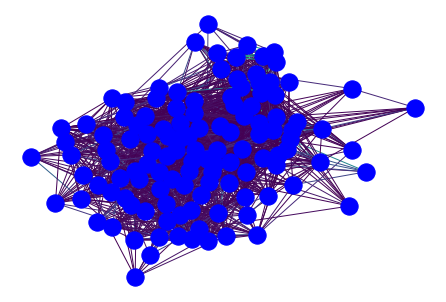

29


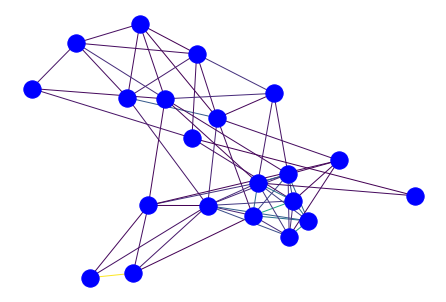

6


In [27]:
#use for Chinese Whispers:
summarize = cw_summarize

#use for TextRank:
#summarize = extract_top

prune = True
weighted_init = True

stemmer = SnowballStemmer(language='english')
tokenizer = RegexpTokenizer(r'\w+')

summaries = []
k = 10

for s in samples:
    raw_sentences = write_sentences(s)
    sentences = []
    counter = Counter()

    for s in raw_sentences:
        words = tokenizer.tokenize(s)
        sentences.append(' '.join(words))
    sentences = list(set(sentences))

    vocab = make_vocab(sentences)
    idf = compute_idf(sentences, vocab)
    vectors = [tf_idf(s, vocab, idf) for s in sentences]

    scores = []

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                scores.append((i, j, similarity(vectors[i], vectors[j])))

    if prune:
        scores = prune_graph(scores)          

    # tops of clusters obtained by PageRank
    top_k = summarize(scores, k = k, weighted_init = weighted_init)

    summaries.append([sentences[i] for i in top_k])

In [67]:
for i, s in enumerate(samples):
    print(s['object1']['name'] + ' vs ' + s['object2']['name'] + ':')
    for sent in summaries[i]:
        print(sent + '.')
    print()

python vs java:
python than for java.
Aside from the perils of late binding the other major concern I have about Python for mission critical apps is that the Python designers didn t include a posse of security paranoids the way Java and JEE did so exploits are potentially more possible.
In practice I find that my Python programs perform somewhat better than Java probably because Python has many libraries implemented in C whereas Java has many pure Java libraries.
Using the decimal library in python with 90 significant digits is massive overkill but I plan to use those results as a baseline for comparison with both the java app and the python app.
most humorously the major reason python is touted over java is the reason you give for java over c python is even more high level than java meaning higher productivity.
BTW AFAIK the python language evolution is managed much in the same way that Java JSR for Java vs PEPs for Python JCP for Java vs PSF for Python.
Python is slower than Java.
Py

### Pretrained Language Model

Language Model inn general is a function that is fitted to maximize probabilty of the tokens sequences from some domain. In this approach we use a reccurent neural model that also learns hidden representation for every token in a given sequence that is aimed to store information about all previous words in the text. Then the next token probability is a function of a privious token representation and  a hidden state: 
$$p(x_{t+1}) = f(h_t, x_t)$$

In this experiment we use LSTM model pretrained on the set retrieved by CAM for all 512 queries. As input representations we use pretrained embeddings from BERT model with original BERT tokenizer. As our domain is pretty wide, it is efficient to use BPE tokens instead of building word-level vocabulary.

We initialize model in two different ways: randomly and by the language model pretrained on WikiText103 dataset. WikiText103 is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia.

As a similarity function here we use cosine distance between hidden representations of the last tokens of sentences:

$$f(h^1_{t_1}, h^2_{t_2}) = \frac {\left<h^1_{t_1}, h^2_{t_2}\right>}{\|h^1_{t_1}\|\|h^2_{t_2}\|}$$,
where $h^i$ is a sequence of hidden states of sentence $i$ and $t_i$ is number of tokens in sentence $i$.

In [29]:
# we will need BERT Tokenizer
!pip install pytorch-pretrained-bert

In [68]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from pytorch_pretrained_bert import *
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [69]:
print (6)

6


In [74]:
from tokenizer_custom_bert import BertTokenizer

In [75]:
tokenizer = BertTokenizer(vocab_file = 'vocab.txt')

Here we just load pretrained model that was initially used for Encoder-Decoder architecture. Training code can be found in MeanSum part of the project.

In [ ]:
data

In [ ]:
data

In [76]:
class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken, ninp = 768, nhid = 512, nlayers=1, dropout=0.5, tie_weights=False):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear( nhid, ntoken)

        self.init_weights()

        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden, input_lengths = None):
        emb = self.drop(self.encoder(input))
        if input_lengths is not None:
            emb = torch.nn.utils.rnn.pack_padded_sequence(emb, input_lengths, enforce_sorted = True)
            outputs, hidden = self.rnn(emb, hidden)
            output, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        else:
            output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output)
        return decoded, hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))
        

def detach_hidden(hidden):
    return (hidden[0].detach(),
            hidden[1].detach())

In [77]:
!ls -lh

total 187M
-rw-r--r-- 1 user user1 380K Jan 29 20:01 TextRank.ipynb
drwxr-xr-x 2 user user1 4.0K Jan 29 19:59 __pycache__
-rw-r--r-- 1 user user1 7.3K Jan 29 19:59 file_utils_custom.py
-rw-r--r-- 1 user user1  20M Jan 29 18:21 mined_bow_str.json
-rw-r--r-- 1 user user1  16K Jan 29 19:59 tokenizer_custom_bert.py
-rw-r--r-- 1 user user1 227K Jan 29 20:04 vocab.txt
-rw-r--r-- 1 user user1 168M Jan 29 19:27 wikitext_lm_finetuned


In [78]:
device = torch.device("cuda")

# one-layered LSTM model pretraied on CAM outputs

#LM = RNNModel(30522, nlayers=1, dropout = 0.0)
#LM.load_state_dict(torch.load('drive/My Drive/summarization/simple_lm'))

# two-layered LSTM pretrained on WikiText103 and finetuned on CAM outputs

LM = RNNModel(30522, nlayers=2, dropout = 0.0)
LM.load_state_dict(torch.load('./wikitext_lm_finetuned'))

LM = LM.to(device)

In [79]:
def similarity(s1, s2):
    return s1.dot(s2)/np.linalg.norm(s1,2)/np.linalg.norm(s2, 2)

In [9]:
import requests

URL = 'http://ltdemos.informatik.uni-hamburg.de/cam-api'
proxies = {"http": "http://185.46.212.97:10015/","https": "https://185.46.212.98:10015/",}
params = {
            'objectA': 'Moscow',
            'objectB': 'London',
            'fs': str(True).lower()}
response = requests.get(url=URL, params=params, proxies=proxies)
s = response.json()

In [14]:
response_json = s
comparing_pair = {}

if (response_json['object1']['name'] == response_json['winner']):
    comparing_pair['winner_aspects'] = response_json['extractedAspectsObject1'][:4]
    comparing_pair['loser_aspects'] = response_json['extractedAspectsObject2'][:4]
    comparing_pair['winner'] = response_json['object1']['name']
    comparing_pair['loser'] = response_json['object2']['name']
else:
    comparing_pair['winner_aspects'] = response_json['extractedAspectsObject2'][:4]
    comparing_pair['loser_aspects'] = response_json['extractedAspectsObject1'][:4]
    comparing_pair['winner'] = response_json['object2']['name']
    comparing_pair['loser'] = response_json['object1']['name']

In [10]:
s = response.json()
#raw_sentences = write_sentences(s)

In [16]:
from template_generation import generate_template
generate_template(comparing_pair, mode="extended")

'i came to the conclusion that london is better, because: greater, safer, bigger, quicker, but moscow is: argument, power, authority, faster'

In [3]:
from cam_summarize import cam_summarize

/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWa

In [5]:
cam_summarize(s)[0]

["LONDON--(Marketwire - Feb 19, 2013) - Stocks ended on a mixed note on Friday's trading session as better-than-expected U.S. economic data was overshadowed by the G20 summit, which was held in Moscow over the weekend.\n",
 'By 1911 that number had grown to a staggering 7 million: a population far greater than Paris, Berlin, St. Petersburg and Moscow combined at that time.\n',
 'When I graduated from University I moved to Moscow, Russia which was a lot easier and a whole heap more fun than getting a job in recession hit 90s London.\n',
 'Next year though he will tweak his preparation and arrive in Moscow for the world championships fresher and smarter than he did when he arrived in London an Olympic debutant.\n',
 "OAO Gazprom and OAO Lukoil's U.S.- traded shares are fetching a discount to their Moscow stock for the first time in three years after oil tumbled faster in New York than in London.\n",
 'The 30-day average value of trades in 10 of the biggest Russian companies tracked by Bl

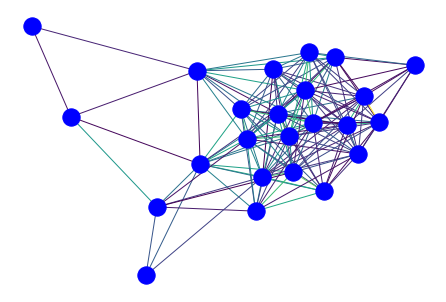

5


In [97]:
summaries = []
sentences = []
for s in raw_sentences:
    s = ["[CLS]"] + tokenizer.tokenize(s) + ["[SEP]"]
    sentences.append(tokenizer.convert_tokens_to_ids(s))

hiddens = []
for s in sentences:
    hidden = LM.init_hidden(1)
    batch = torch.LongTensor([s]).transpose(0, 1).to(device)
    preds, h = LM(batch, hidden, input_lengths = None)
    hiddens.append(h[1].view(-1).cpu().detach().numpy())

scores = []

for i in range(len(sentences)):
    for j in range(len(sentences)):
        scores.append((i, j, similarity(hiddens[i], hiddens[j])))

if prune:
    scores = prune_graph(scores)

top_k = summarize(scores, k = k, weighted_init = weighted_init)

summaries.append([raw_sentences[i] for i in top_k])

In [98]:
summaries

[["To those Russians, Prague is a more affordable version of London: an urban asylum that's safer and more civilized than teeming, lawless Moscow, and a convenient few hours' flight away.\n",
  'On the return journey I travelled via Astana and as a result made the journey from Almaty to London in under 5 days, about 13 hours quicker than using the direct train from Almaty to Moscow (train 7/8).\n',
  'Since the incursion into the Black Sea peninsula on March 1, investors turned to offshore equity trading, with London volume growing faster than that of Moscow.\n',
  "OAO Gazprom and OAO Lukoil's U.S.- traded shares are fetching a discount to their Moscow stock for the first time in three years after oil tumbled faster in New York than in London.\n",
  "All right, it's a lot smaller than London (as many people live in Greater London as in all of Belgium) or Moscow, but I get the feeling you only saw a tiny little bit of it.\n"]]

In [92]:
for sent in summaries:
    print(sent[:-1])
print()

IndexError: list index out of range

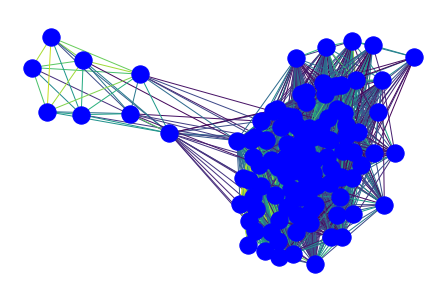

7


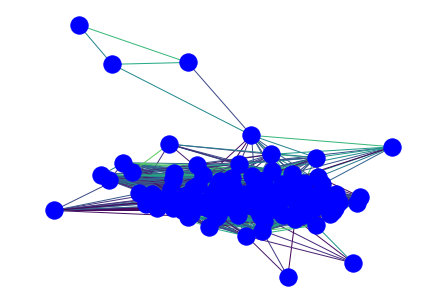

4


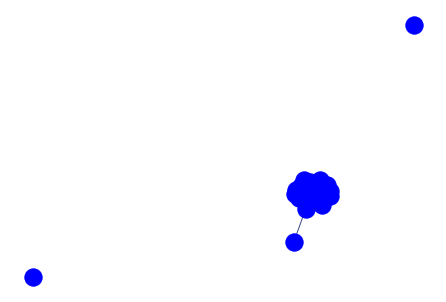

4


In [87]:
#use for Chinese Whispers:
summarize = cw_summarize

#use for TextRank:
#summarize = extract_top

prune = True
weighted_init = True

summaries = []
k = 10

for s in samples:
    raw_sentences = write_sentences(s)
    sentences = []
    for s in raw_sentences:
        s = ["[CLS]"] + tokenizer.tokenize(s) + ["[SEP]"]
        sentences.append(tokenizer.convert_tokens_to_ids(s))

    hiddens = []
    for s in sentences:
        hidden = LM.init_hidden(1)
        batch = torch.LongTensor([s]).transpose(0, 1).to(device)
        preds, h = LM(batch, hidden, input_lengths = None)
        hiddens.append(h[1].view(-1).cpu().detach().numpy())

    scores = []

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            scores.append((i, j, similarity(hiddens[i], hiddens[j])))

    if prune:
        scores = prune_graph(scores)

    top_k = summarize(scores, k = k, weighted_init = weighted_init)

    summaries.append([raw_sentences[i] for i in top_k])

In [88]:
for i, s in enumerate(samples):
    print(s['object1']['name'] + ' vs ' + s['object2']['name'] + ':')
    for sent in summaries[i]:
        print(sent[:-1])
    print()

python vs java:
Python is easier to program in than Java.
Writing it in python is probably faster than java.
Learn Python instead of Java as your first language .
compliant with Java than Python 2.5.)
I'm writing this project in Java instead of Python.
Hell, Python runtime is much smaller than Java or .
I'm using the Python version of the API, so a Python solution would be preferred, but I know Java well enough that I could translate a Java solution into Python.

toyota vs nissan:
The Nissan provided better ride and handling than the Toyota.
I would pefer the toyota over the nissan anyday!
I know Toyota owners are smarter than Nissan owners.)
Needless to say Nissan do not even compare to the appointed Toyota dealership.

tea vs juice:
Pomegranate juice has more polyphenol antioxidants than red wine, green tea, cranberry juice and orange juice.
But I was in hurry to taste her love juice first rather than tea or lichi juice etc.
Variations: Top with cranberry juice instead of cola to mak